In [2]:
import pandas as pd
from sdatta_learn.loader.load_from_postgres import get_all_table, get_sales_between_dates
import os

In [3]:
sales_data = pd.read_csv('/Users/guybasson/Desktop/sdatta-nlp/palmers_fashion/f_sales_v_fashion.csv')

In [4]:
sales_data['item'] = sales_data['sku'].astype(str).str[:12]

In [11]:
sales_data_g_item = sales_data.groupby(['date','item'])['sales'].sum().reset_index()

In [12]:
sales_data_g_item['date'] = pd.to_datetime(sales_data_g_item['date'])

In [13]:
# sales of sum for each item in 2023 that are large then 0 and fashiongrade is 'M'
items_sales_in_2023 = sales_data_g_item[sales_data_g_item['date'].dt.year == 2023].groupby('item')['sales'].sum().sort_values(ascending=False)[sales_data_g_item[sales_data_g_item['date'].dt.year == 2023].groupby('item')['sales'].sum().sort_values(ascending=False) > 0].index


/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_77553/2314778218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['item'] = sales_data['sku'].astype(str).str[:12]


In [14]:
fashiongrade

In [15]:
import matplotlib.pyplot as plt
for item in items_sales_in_2023[:30]:
    item_data = sales_data_g_item[sales_data_g_item['item'] == item].set_index('date')['sales']
    fashiongrade = sales_data[sales_data['item'] == item]['fashiongrade'].unique()[0]
    # reindex to fill in missing dates
    item_data = item_data.reindex(pd.date_range(start=sales_data_g_item['date'].min(),
                                                # today
                                                end=sales_data_g_item['date'].max(),

                                                freq='D')).fillna(0)
    item_data_w = item_data.resample('W').sum()
    # fig size
    plt.figure(figsize=(20,4))
    plt.title('item: ' + item + ' fashiongrade: ' + str(fashiongrade))
    item_data_w.plot()
    plt.show()

In [16]:
sales_data_g_item['item'].nunique()

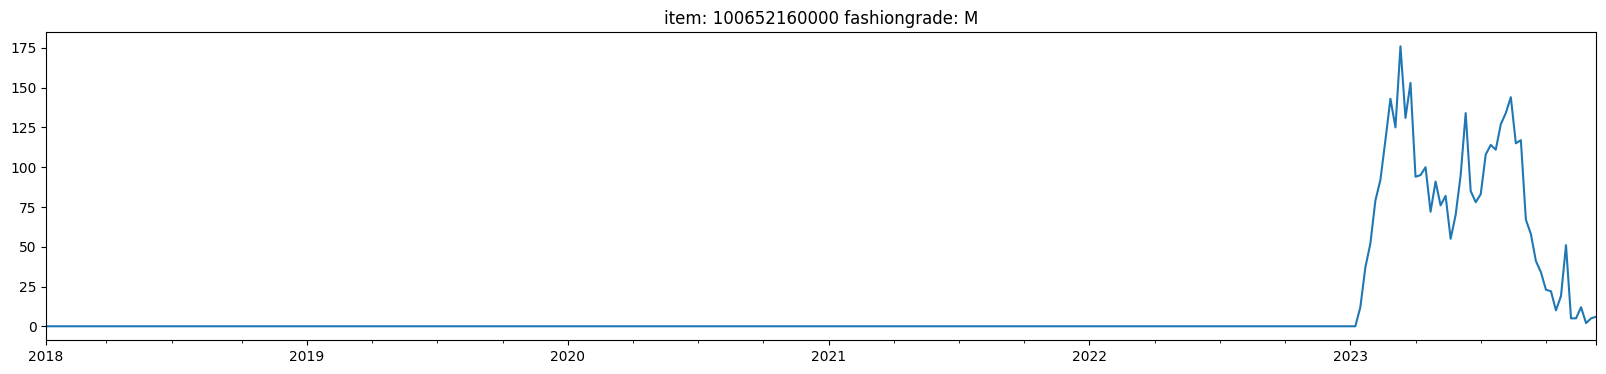

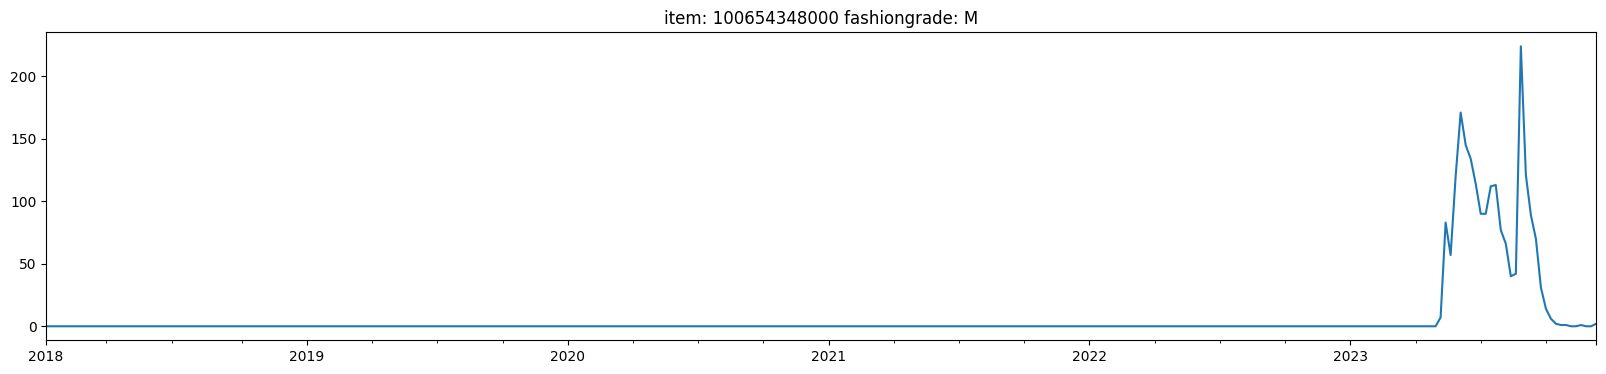

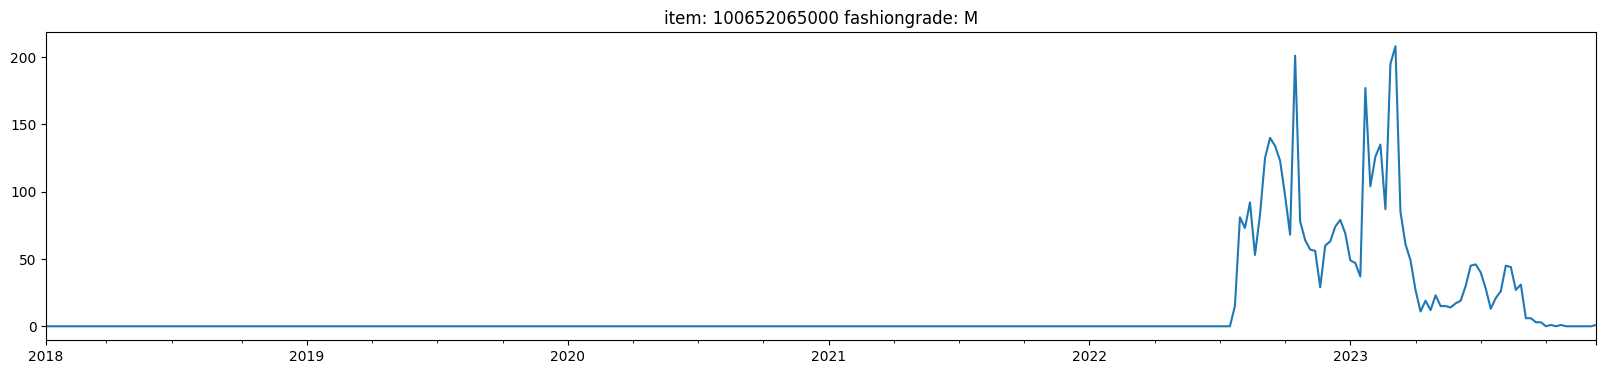

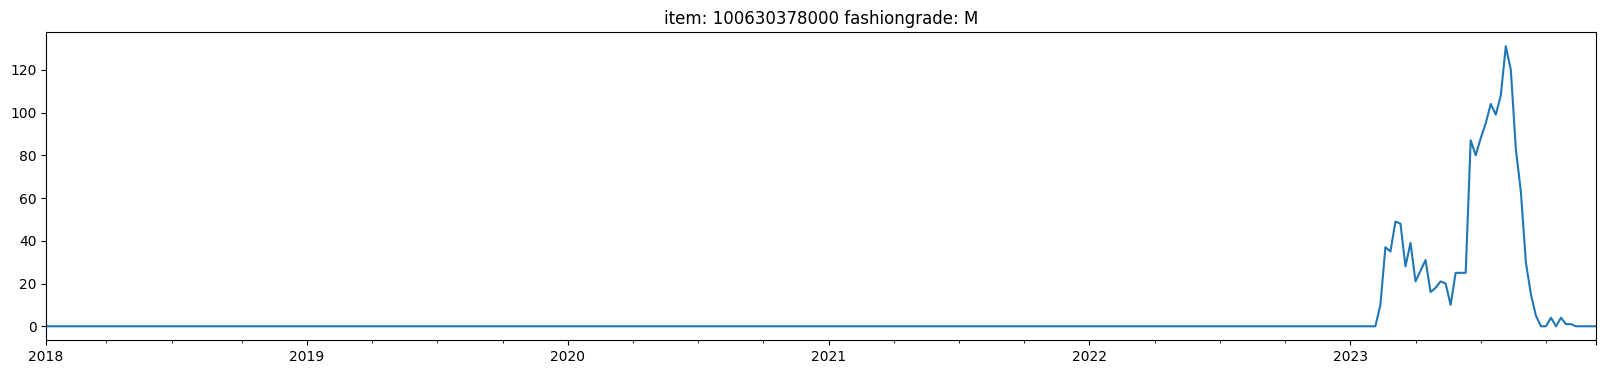

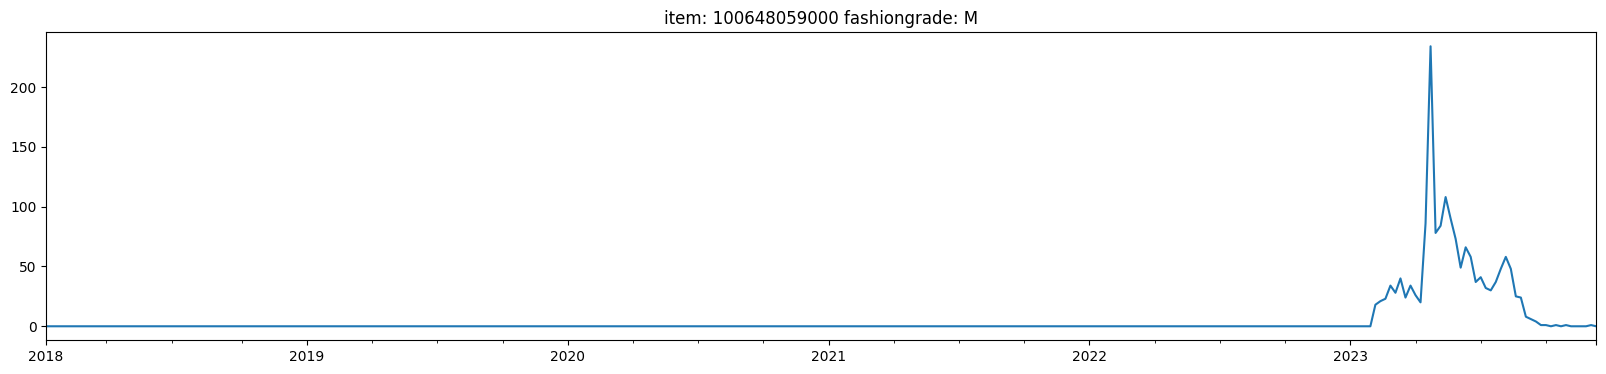

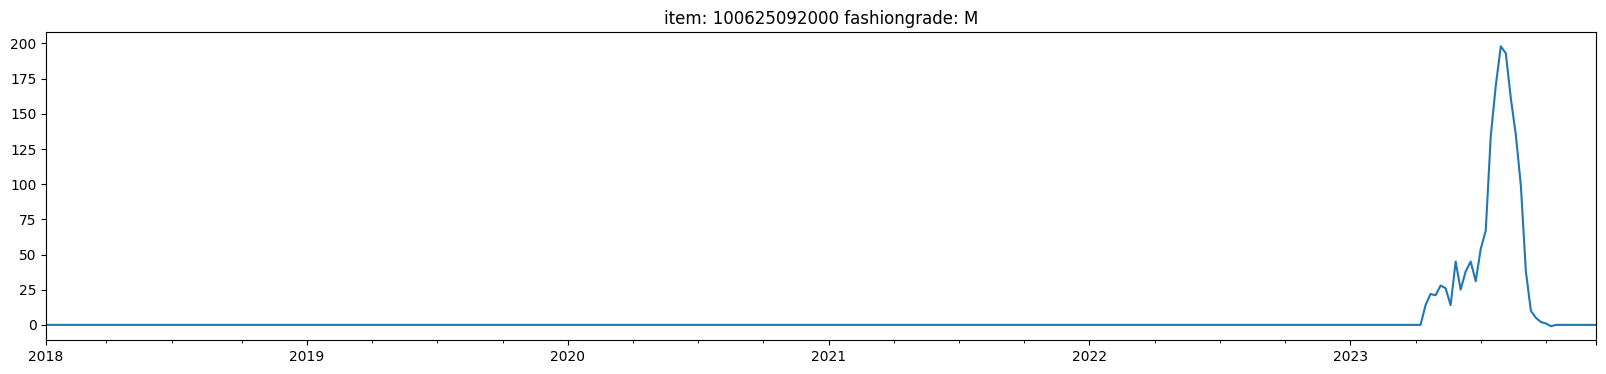

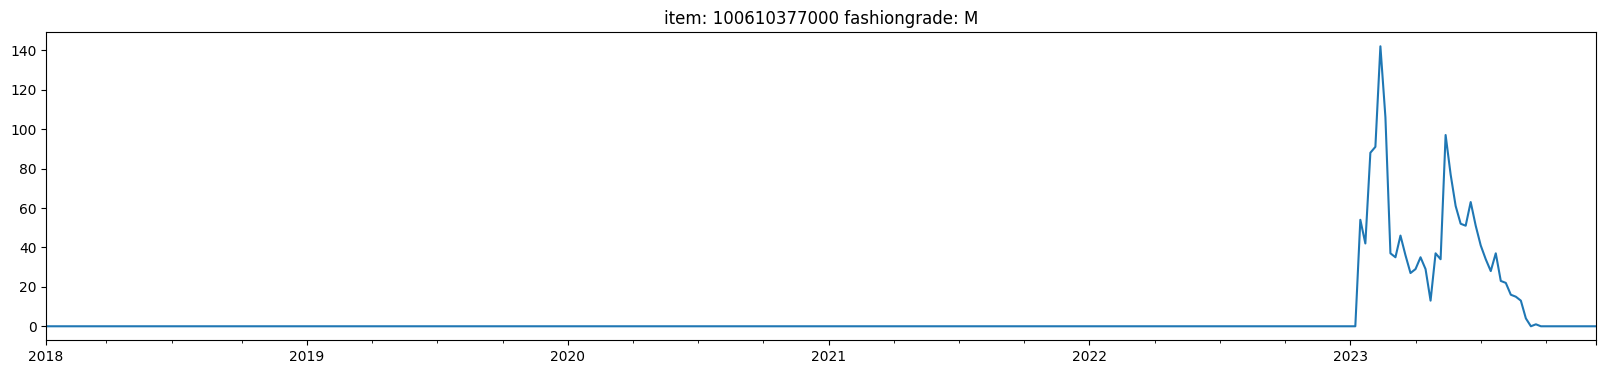

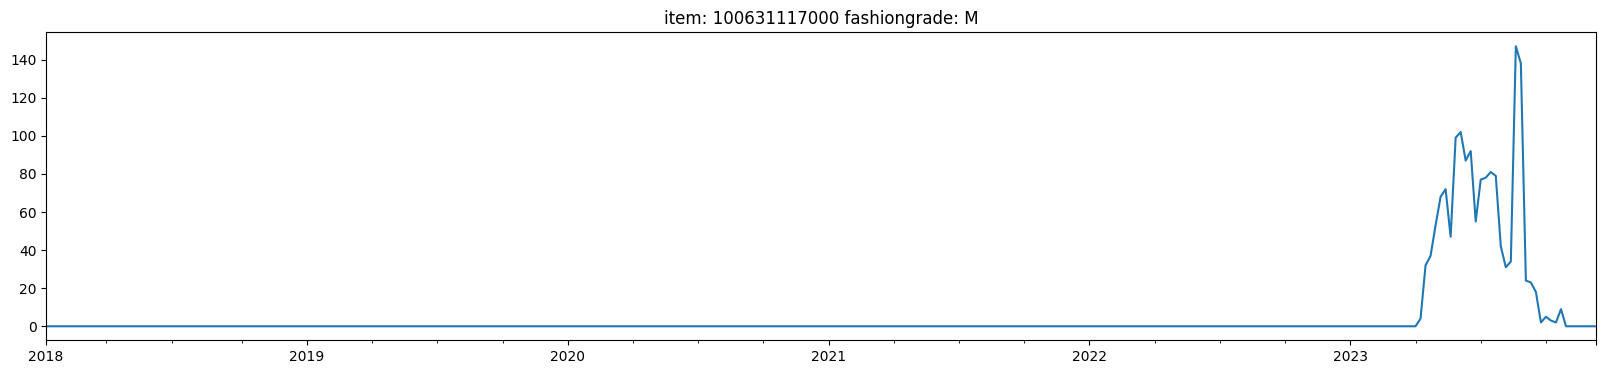

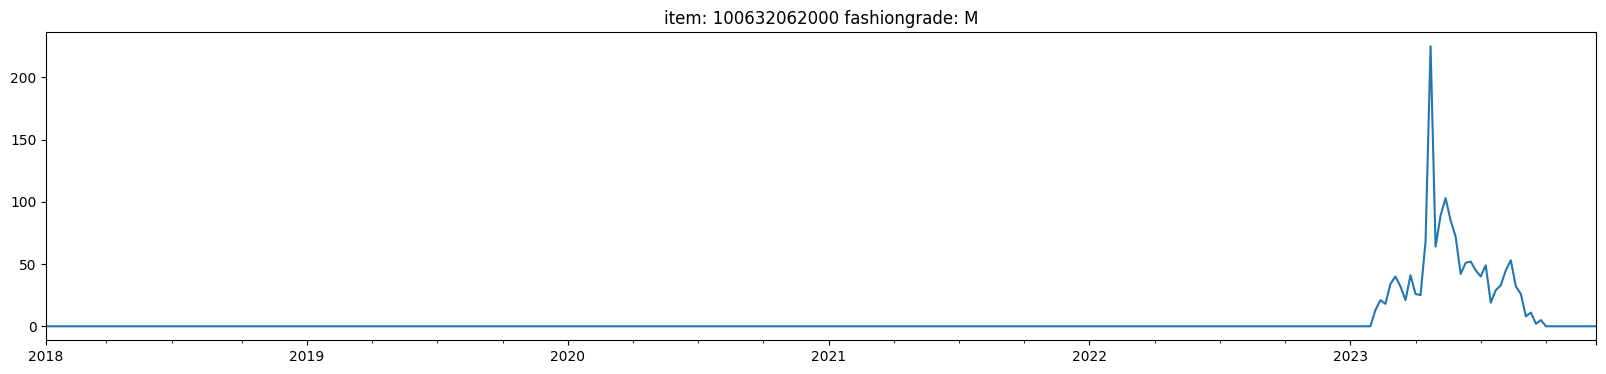

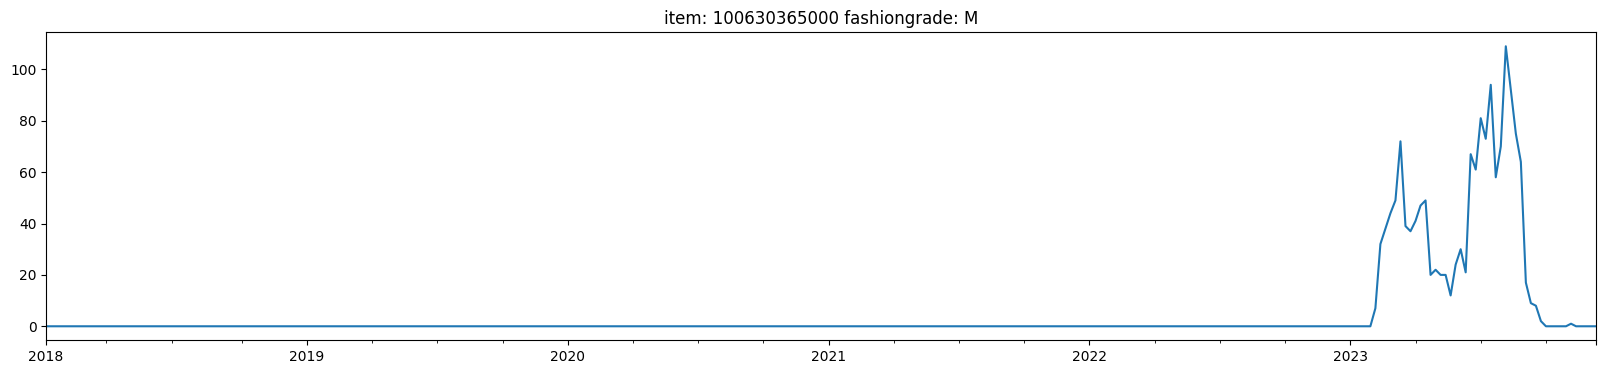

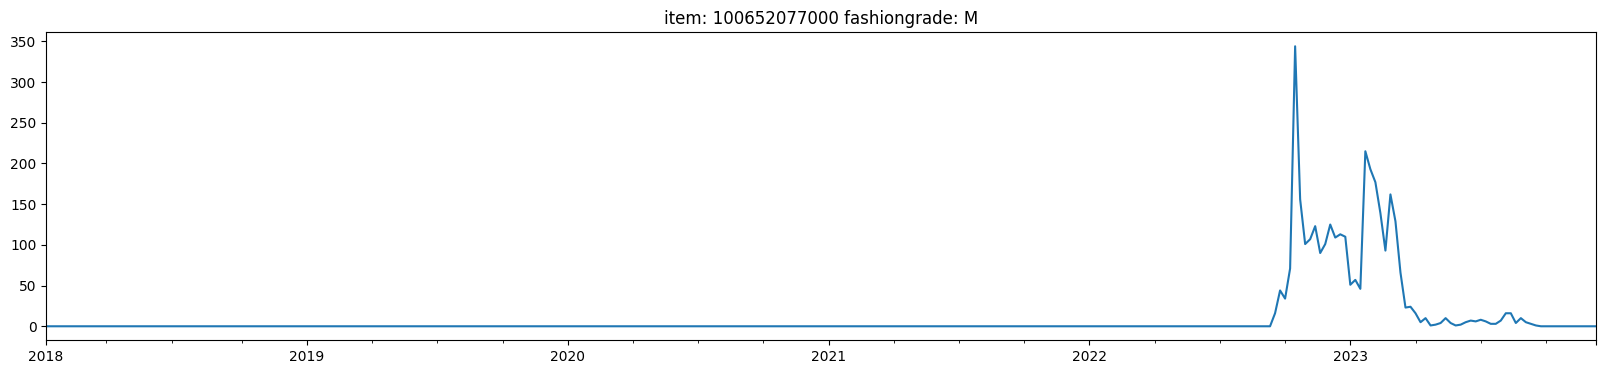

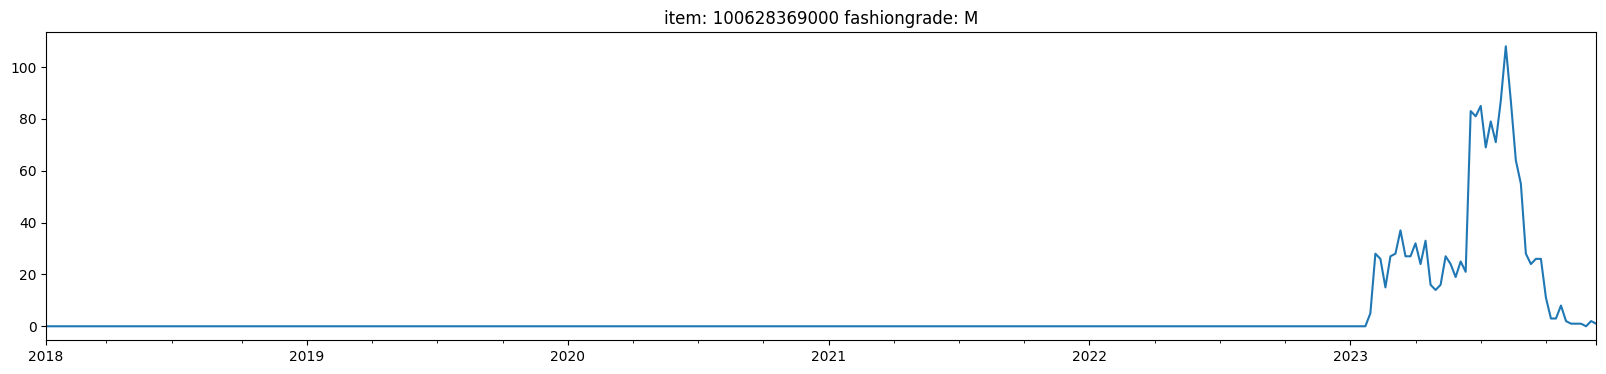

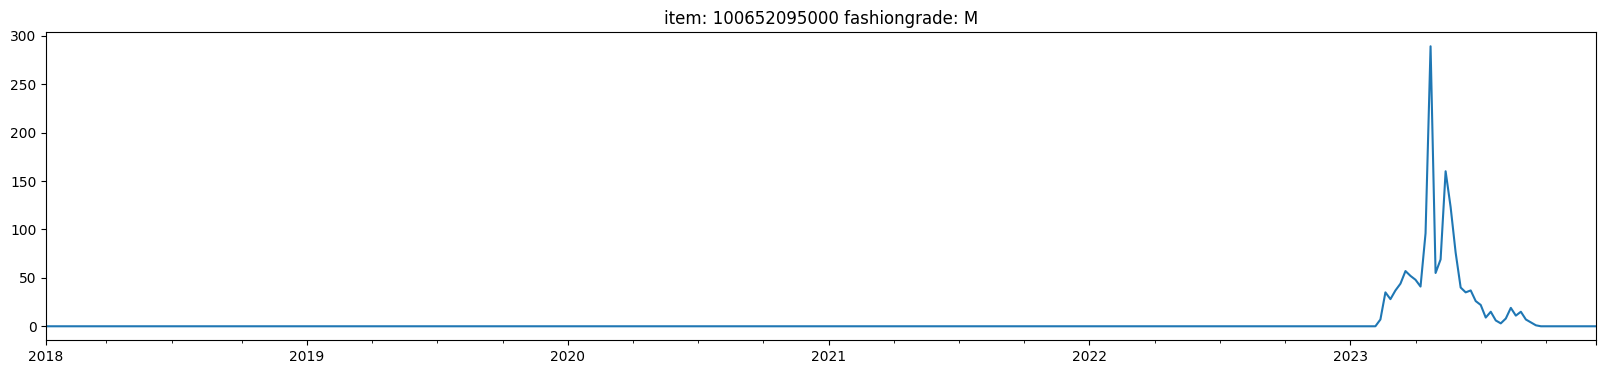

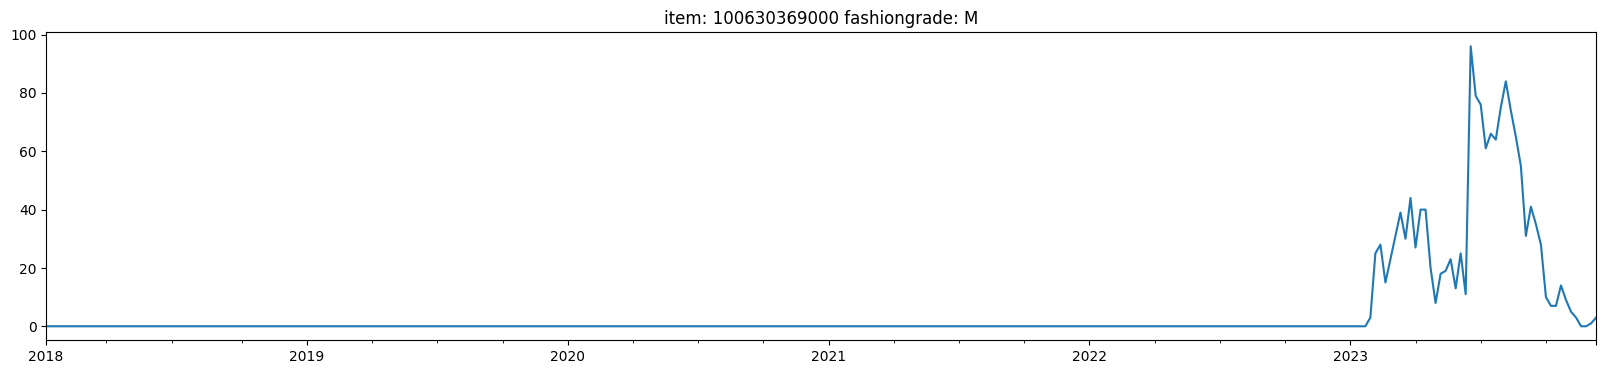

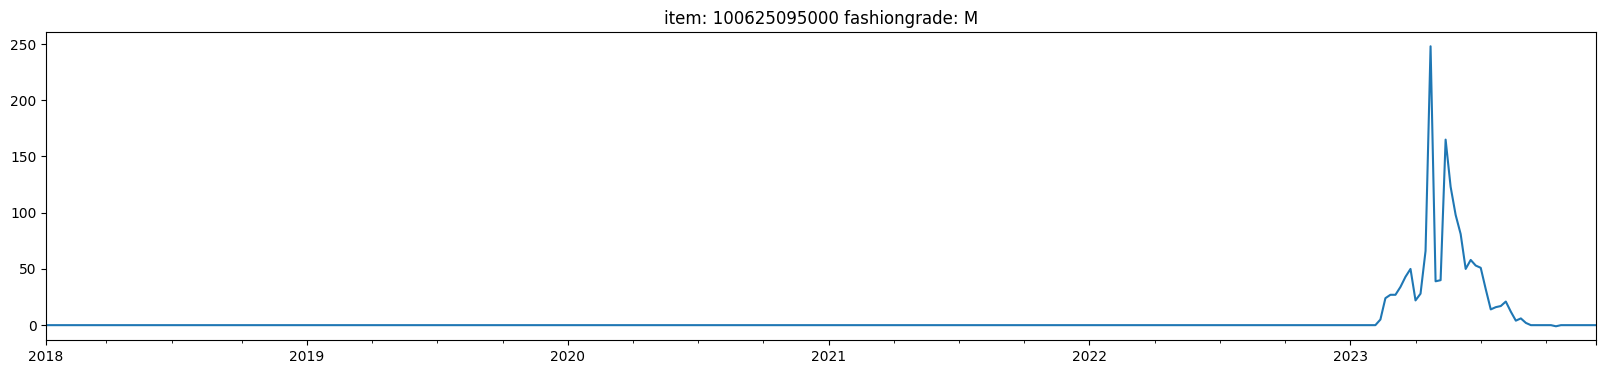

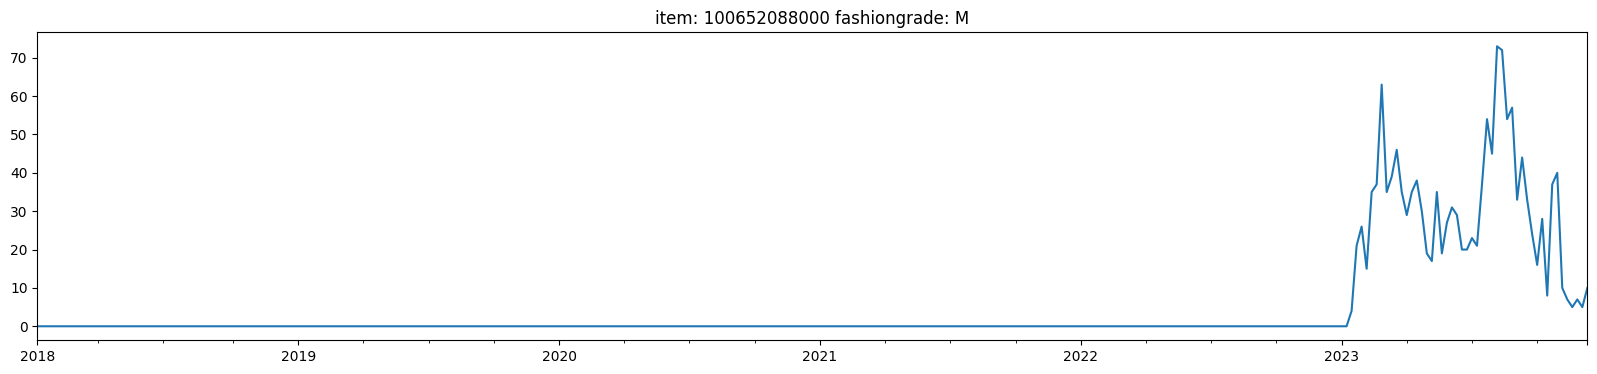

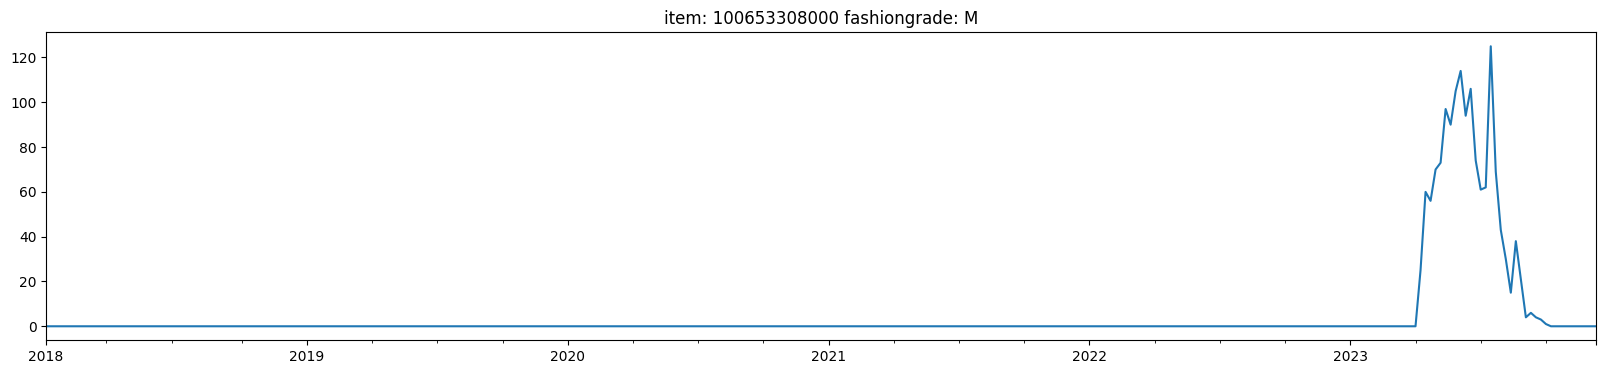

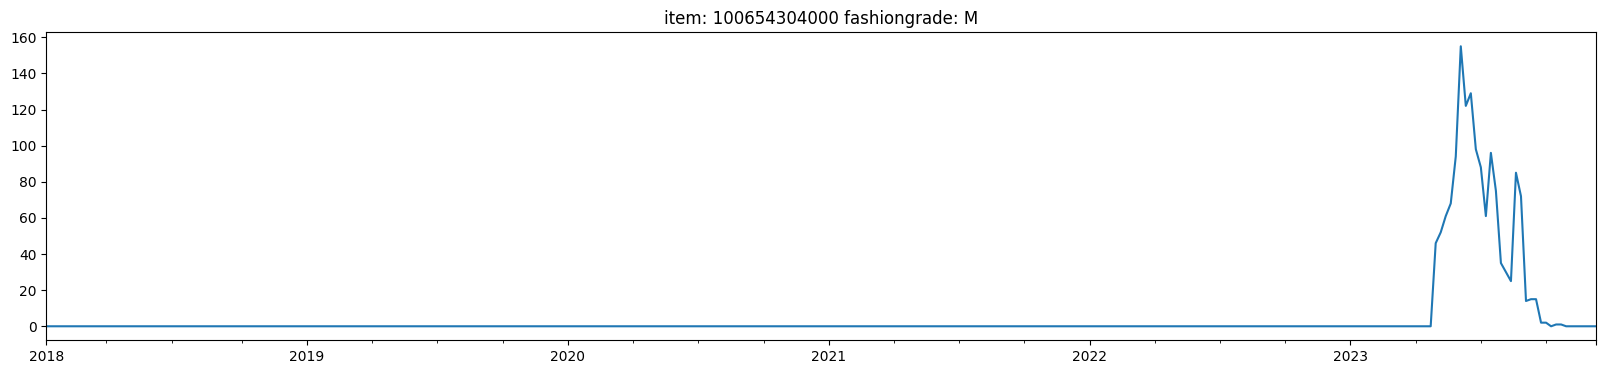


KeyboardInterrupt



In [17]:
item_data.set_index('date')


5459